In [1]:
using LinearAlgebra

using Plots
default(fmt = :png)

using DifferentialEquations
using Flux
using DiffEqFlux

In [2]:
const N = 64
const L = 2
const Δx = L / N
const κ = 1

x = range(-L/2, L/2, length=N)

datasize = 30
tspan = (0.0, 0.1)
t = range(tspan[1], tspan[2], length=datasize)

0.0:0.0034482758620689655:0.1

In [3]:
 d = -2 * ones(N)
sd = ones(N-1)
A = Array(Tridiagonal(sd, d, sd))
A[1, N] = 1
A[N, 1] = 1
A_diffusion = (κ/Δx^2) .* A

function diffusion(∂u∂t, u, p, t)
    ∂u∂t .= A_diffusion * u
    return
end

diffusion (generic function with 1 method)

In [41]:
u₀s = [
    x -> 0.5,
    x -> exp(-50x^2),
    x -> exp(-20x^2),
    x -> cos(π*x),
    x -> cos(2π*x),
    x -> sin(π*x),
    x -> sin(2π*x)
]

7-element Array{Function,1}:
 getfield(Main, Symbol("##73#80"))()
 getfield(Main, Symbol("##74#81"))()
 getfield(Main, Symbol("##75#82"))()
 getfield(Main, Symbol("##76#83"))()
 getfield(Main, Symbol("##77#84"))()
 getfield(Main, Symbol("##78#85"))()
 getfield(Main, Symbol("##79#86"))()

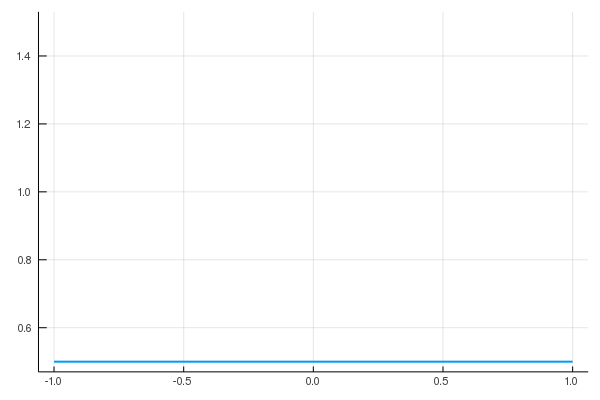

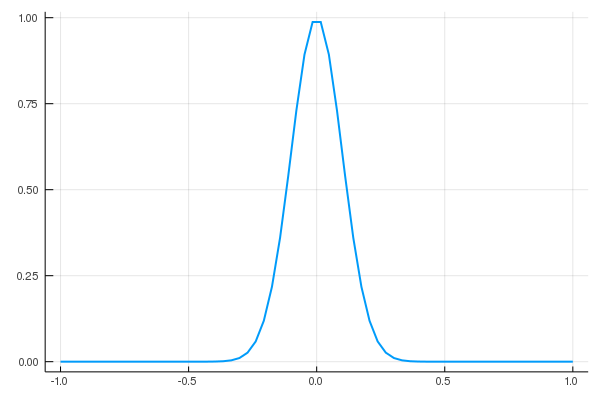

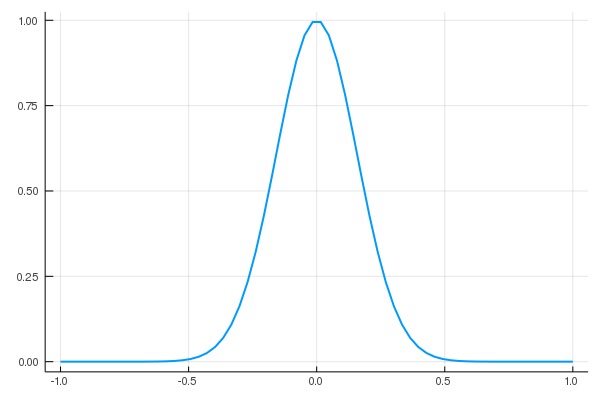

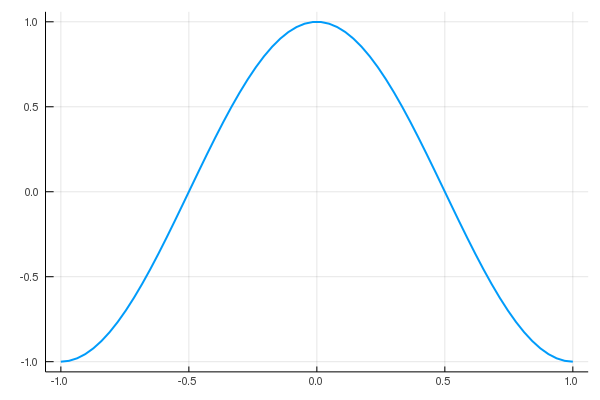

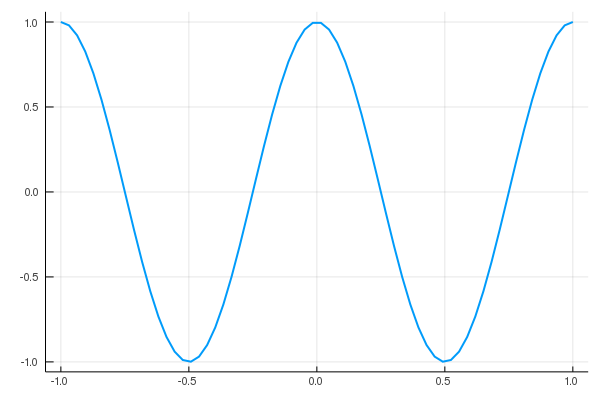

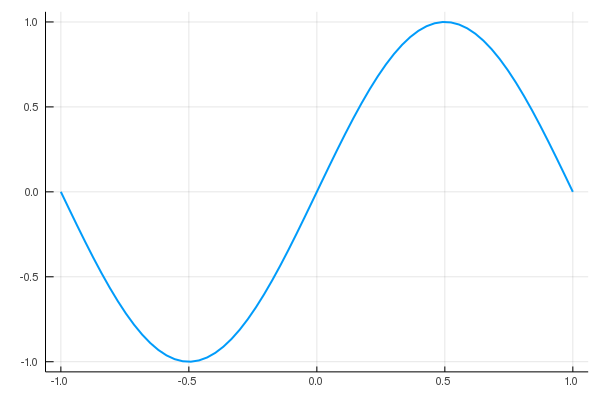

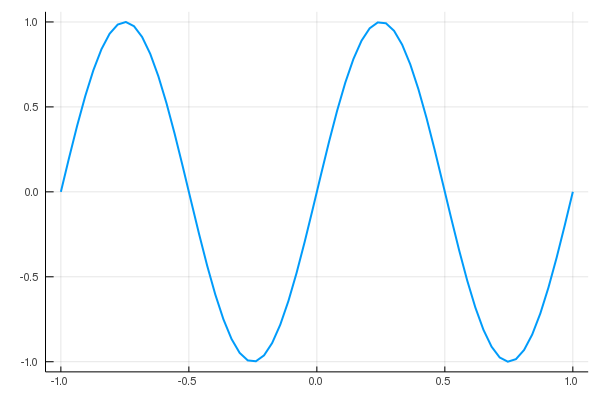

In [42]:
for u₀ in u₀s
    display(plot(x, u₀.(x), linewidth=2, label=""))
end

In [43]:
pde_data = []
for (i, u₀) in enumerate(u₀s)
    println("Generating PDE data with initial condition $i...")
    
    u₀_ic = @. u₀(x)
    prob = ODEProblem(diffusion, u₀_ic, tspan)
    solution = Array(solve(prob, Tsit5(), saveat=t))
    
    push!(pde_data, solution)
end

Generating PDE data with initial condition 1...
Generating PDE data with initial condition 2...
Generating PDE data with initial condition 3...
Generating PDE data with initial condition 4...
Generating PDE data with initial condition 5...
Generating PDE data with initial condition 6...
Generating PDE data with initial condition 7...


In [22]:
dudt_NN = Chain(Dense(N, N, tanh),
                Dense(N, N))

ps = Flux.params(dudt_NN)

neural_pde_prediction = u₀ -> neural_ode(dudt_NN, u₀, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

#41 (generic function with 1 method)

In [23]:
data = Iterators.repeated((), 1000)
opt = ADAM(0.1)

In [44]:
M = length(u₀s)
loss_function() = sum(sum(abs2, pde_data[i] .- neural_pde_prediction(u₀s[i].(x))) for i in 1:M)

loss_function (generic function with 1 method)

In [45]:
# Callback function to observe training.
cb = function ()
    loss = loss_function()
    println("loss = $loss")
    loss < 10 && Flux.stop()
end

#89 (generic function with 1 method)

In [46]:
Flux.train!(loss_function, ps, data, opt, cb = cb)

loss = 662.4183329651247 (tracked)
loss = 419.78431740562905 (tracked)
loss = 340.52352906982185 (tracked)
loss = 254.4343531793574 (tracked)
loss = 182.6757798714018 (tracked)
loss = 154.38537440729917 (tracked)
loss = 107.09253259619157 (tracked)
loss = 97.44308801544386 (tracked)
loss = 78.78055128418094 (tracked)
loss = 62.97983948796745 (tracked)
loss = 54.720562700712954 (tracked)
loss = 56.416105160677915 (tracked)
loss = 52.70986110122965 (tracked)
loss = 57.51765643252073 (tracked)
loss = 57.41640403692358 (tracked)
loss = 60.00494114408757 (tracked)
loss = 53.38355102887268 (tracked)
loss = 52.583528238107135 (tracked)
loss = 55.40275078886071 (tracked)
loss = 59.125290999274135 (tracked)
loss = 61.71630250402568 (tracked)
loss = 64.2756338813776 (tracked)
loss = 62.45837287644463 (tracked)
loss = 59.589252108418926 (tracked)
loss = 60.6798239597117 (tracked)
loss = 60.55540064198442 (tracked)
loss = 60.5080385293264 (tracked)
loss = 60.37682154143615 (tracked)
loss = 62.7540

InterruptException: InterruptException:

In [36]:
for (i, (u₀, pde_data_i)) in enumerate(zip(u₀s, pde_data))
    u₀_ic = @. u₀(x)
    nn_pred = Flux.data(neural_pde_prediction(u₀_ic))
    
    println("Creating .gif for data from initial condition $i...")
    anim = @gif for n=1:datasize
        plot(x, pde_data_i[:, n], linewidth=2, ylim=(-1, 1), label="data", show=false)
        plot!(x, nn_pred[:, n],   linewidth=2, ylim=(-1, 1), label="Neural PDE", show=false)
    end
    
    display(anim)
end

Creating .gif for data from initial condition 1...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 2...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

Creating .gif for data from initial condition 3...


┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

Creating .gif for data from initial condition 4...


┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

Creating .gif for data from initial condition 5...


┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [37]:
u₀s_test = [
    x -> 0.8,
    x -> exp(-50*abs(x)),
    x -> cos(π*x + π/2),
    x -> sin(π*x - π/2)
]

4-element Array{Function,1}:
 getfield(Main, Symbol("##65#69"))()
 getfield(Main, Symbol("##66#70"))()
 getfield(Main, Symbol("##67#71"))()
 getfield(Main, Symbol("##68#72"))()

In [40]:
for (i, u₀) in enumerate(u₀s_test)
    u₀_ic = (@. u₀(x))
    
        prob = ODEProblem(diffusion, u₀_ic, tspan)
    solution = solve(prob, Tsit5(), saveat=t)
    
    nn_pred = Flux.data(neural_pde_prediction(u₀_ic))
    
    println("Creating .gif for data from initial condition $i...")
    anim = @gif for n=1:datasize
        plot(x, solution[:, n], linewidth=2, ylim=(-1, 1), label="data", show=false)
        plot!(x, nn_pred[:, n], linewidth=2, ylim=(-1, 1), label="Neural ODE", show=false)
    end
    
    display(anim)
end

Creating .gif for data from initial condition 1...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 2...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 3...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 4...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95
